# External GEO dataset: parsing the data

In this Python Notebook we will construct the dataset used to evaluate the XGBoost models generated previously. 

The output of this code will be the datasets "all_data_geo" and "all_labels_geo", which will contain the list of samples (Gene Expression normalized using TPM format) of the 10 different cancer types that are part of this thesis and the labels of each sample, respectively.

In [1]:
import pandas as pd
import pickle
import os
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

Similarly to the approach in the module for parsing TCGA data, we will maintain a running list of mapping from raw values ancountered while parsing all samples and interactively ask the user to identify the unseen sample labels.

In [2]:
ignored_tissues_geo_file_path = "ignored_tissues_list_geo.pkl"
class_mapping_geo_file_path = "class_mapping_geo.pkl"

# class mapping
class_mapping_geo = {}
# ignore unknown tissues
ignored_tissues_geo = []

# load the files if they exist

if os.path.exists(class_mapping_geo_file_path):

    # load the list of ignored tissues from a pickel file
    with open(ignored_tissues_geo_file_path, 'rb') as f: 
        ignored_tissues_geo = pickle.load(f)

    # load a dataframe with the labels of each sample from a pickel file
    with open(class_mapping_geo_file_path, 'rb') as f: 
        class_mapping_geo = pickle.load(f)

GEO data stores the TPM values for each gene identified with a Gene ID. What we need is to replace that with gene symbol, so we can match it with each column of the TCGA data.

Each study in GEO is identified by a unique asseccion number. When searching for the studies we were trying to make sure our sample distribution was more or less balanced. This is why each individual cancer type has one or more studies, each one determined by its accession ID.

Once we have downloaded all of the studies we want to include in our data we hardcode the mappings of each cancer type to the list of accession numbers for studies which belong to it.

In [3]:
datasets = {
    "bladder":["GSE229410", "GSE216037"],
    "brain":["GSE119834", "GSE213527"],
    "breast":["GSE147356"],
    "colon":["GSE180440", "GSE146009"],
    "liver":["GSE144269", "GSE77314"],
    "lung":["GSE60052"],
    "pancreas": ["GSE131050-GPL18573", "GSE131050-GPL16791"],
    "prostate": ["GSE229904"],
    "skin":["GSE142441"],
    "cancers":["GSE184398"]
}

Next, we need to build a function which will extract the input and output data frame for a given study. Each GEO study has three files:
1. series file, containing information about labels (cancer types)
2. annotation file, containing gene symbols for each sample
3. tpm file, containing all of the normalized gene counts

We will parse them to construct a single TPM data table and a matching labels data frame in the same format as TCGA train/validation dataset.

In [4]:
def extract_data(serie, annot, tpm):

     # READ ANNOTATION FILE (to get Gene Symbol)
    df_symbols = pd.read_csv(annot, sep='\t', dtype={"ChrStart": str, "ChrStop": str})

    # READ TPM FILE
    df_tpm = pd.read_csv(tpm, sep='\t')


    # Replace GeneID with Symbol by deleting the column GeneID in df_tpm and inserting the symbol colum from df_symbol in index 0
    df_tpm.drop("GeneID", inplace=True, axis=1)

    df_tpm.insert(0, "Symbol", df_symbols["Symbol"])

    # Set Symbol as index
    df_tpm.set_index("Symbol", inplace=True)

    # Transpose the DataFrame
    all_data_geo = df_tpm.transpose()
    #print(all_data_geo)

    
    # EXTRACTING THE LABELS

    # Open the files in read mode
    with open(serie, 'r') as file:
        lines = file.readlines()

    # Extract the values starting with "GSM"
    gsm_values = []
    for line in lines:
        if line.startswith("!Sample_geo_accession"):
            # Split the line by whitespace and get the values starting from index 1
            gsm_values = line.split()[1:]
            break

    # Extract the information from the specified column
    column_data = []
    for line in lines:
        if line.startswith("!Sample_characteristics_ch1"):
            columns = line.split("\t")
            column_data = [column.strip().split(":")[1].strip().replace('"', '').lower() for column in columns[1:]]  # Assuming the desired column index is 1
            break

    # Create a DataFrame with sample IDs and tissue information
    samples_labels = pd.DataFrame({"Sample ID": [gsm.strip('"') for gsm in gsm_values], "Tissue": column_data})

    # Setting Sample ID as index
    all_labels_geo = samples_labels.set_index("Sample ID")

    # aligning/matching each row of labels with all_data_geo based on Sample ID
    indices = all_data_geo.index
    idx = [x in all_labels_geo.index for x in indices]
    indices = indices[idx]
    all_labels_geo = all_labels_geo.loc[indices]

    filtered_labels = []
    filtered_data = []

    for i in range(all_labels_geo.shape[0]):

        if all_labels_geo.iloc[i][0] in ignored_tissues_geo:
            continue

        row = pd.DataFrame(all_data_geo.iloc[i]).T

        if all_labels_geo.iloc[i][0] in class_mapping_geo.keys():
            filtered_labels.append(class_mapping_geo[all_labels_geo.iloc[i][0]])
            filtered_data.append(row)

        else:
            # request user to insert the label
            mapping = input(f'Insert label for \"{all_labels_geo.iloc[i][0]}\": ')
            if mapping == "":
                ignored_tissues_geo.append(all_labels_geo.iloc[i][0])

            else:
                class_mapping_geo[all_labels_geo.iloc[i][0]] = mapping
                filtered_labels.append(mapping)
                filtered_data.append(row)

    
    # create a DataFrame with only the values of the "Tissue" column
    labels = pd.DataFrame({"Tissue": filtered_labels})
    data = pd.concat(filtered_data, axis=0)

    return (data, labels)

The function we've defined will accept 3 files describing a single GEO study and wil return a tupple with input TPM data and output cancer types for each sample.

The only remaining thing is looping through each study of each cancer type we have manually defined at the beginning in our "datasets" dictionary.

In [5]:
all_tpms = []
all_labels = []

# iterate through all cancer types
for cancer_type in datasets.keys():
    # iterate through all accession IDs (studies) for the given cancer type
    for accession_number in datasets[cancer_type]:

        # directory paths
        serie = f"./data/data-geo/{cancer_type}/{accession_number}_series_matrix.txt"
        annot = f"./data/data-geo/{cancer_type}/Human.GRCh38.p13.annot_{accession_number}.tsv"
        tpm = f"./data/data-geo/{cancer_type}/{accession_number}_norm_counts_TPM_GRCh38.p13_NCBI.tsv"

        result = extract_data(serie, annot, tpm)
        all_tpms.append(result[0])
        all_labels.append(result[1])
        
        print(f"Extracted {result[0].shape[0]} samples from study {accession_number}.")

all_tpms_df = pd.concat(all_tpms, axis=0)
all_labels_df = pd.concat(all_labels, axis=0)

print(all_tpms_df.shape)
print(all_labels_df.shape)

Extracted 41 samples from study GSE229410.
Extracted 36 samples from study GSE216037.
Extracted 96 samples from study GSE119834.
Extracted 100 samples from study GSE213527.
Extracted 235 samples from study GSE147356.
Extracted 108 samples from study GSE180440.
Extracted 65 samples from study GSE146009.
Extracted 140 samples from study GSE144269.
Extracted 100 samples from study GSE77314.
Extracted 75 samples from study GSE60052.
Extracted 124 samples from study GSE131050-GPL18573.
Extracted 66 samples from study GSE131050-GPL16791.
Extracted 140 samples from study GSE229904.
Extracted 117 samples from study GSE142441.
Extracted 655 samples from study GSE184398.
(2098, 39376)
(2098, 1)


We have successfully extracted 2098 samples, each one with normalized counts (TMPs) for 39376 genes. We will store them on the disk in pickle files for the next script and visualize the data distributions.

In [6]:
all_labels_file_path = "all_labels_geo.pkl"
all_data_file_path = "all_data_geo.pkl"

# store the count matrices and labels into pickle files
with open(all_data_file_path, 'wb') as f:
    pickle.dump(all_tpms_df, f)
with open(all_labels_file_path, 'wb') as f:
    pickle.dump(all_labels_df, f)


# store the count matrices and labels into pickle files
with open(ignored_tissues_geo_file_path, 'wb') as f:
    pickle.dump(ignored_tissues_geo, f)
with open(class_mapping_geo_file_path, 'wb') as f:
    pickle.dump(class_mapping_geo, f)

# Data distribution

Similarly to the previous step, we will show the distribution of the cancer types accross the data.

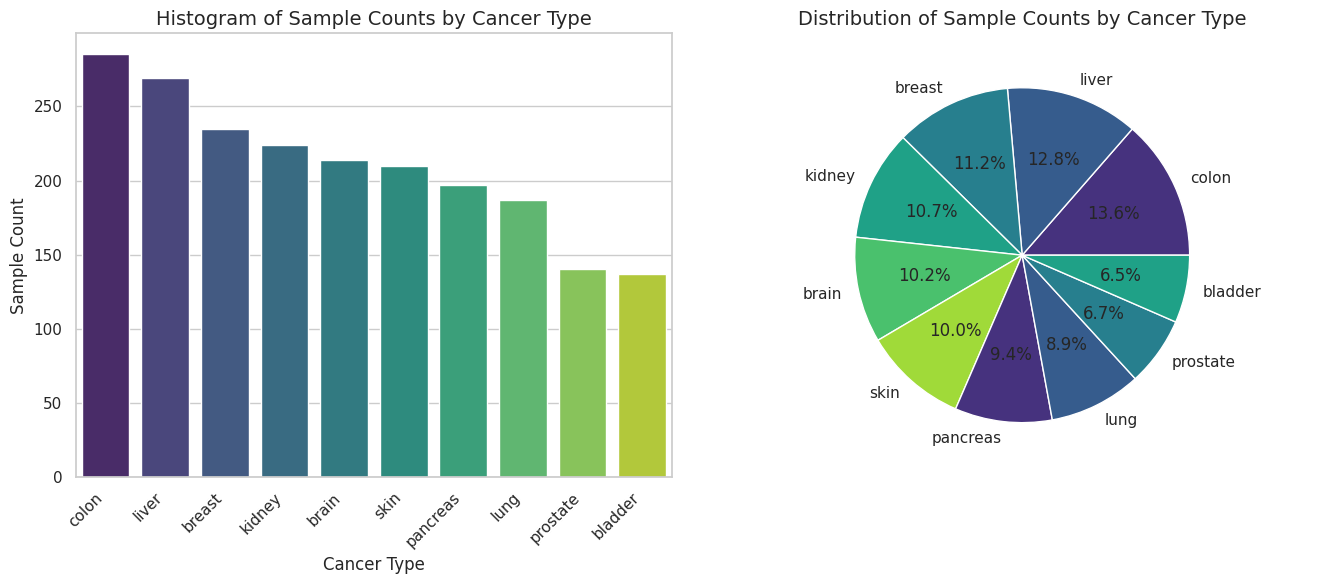

In [20]:
# Count the samples for each cancer type
sample_counts = all_labels_df['Tissue'].value_counts()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes for both subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the bar plot
bar_plot = sns.barplot(x=sample_counts.index, y=sample_counts.values, palette="viridis", ax=ax1)
bar_plot.set_xlabel('Cancer Type', fontsize=12)
bar_plot.set_ylabel('Sample Count', fontsize=12)
bar_plot.set_title('Histogram of Sample Counts by Cancer Type', fontsize=14)
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")

# Plotting the pie chart
pie_plot = ax2.pie(sample_counts.values, labels=sample_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis"), startangle=00)
ax2.set_title('Distribution of Sample Counts by Cancer Type', fontsize=14)
ax2.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

# Adjust the spacing between titles and charts
plt.subplots_adjust(top=1.1)  # Increase the top margin

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

We can see our GEO dataset is fairly balanced, but it's worth of noting that in comparison to the training dataset the distribution is slightly different.

## t-SNE

We will compute the t-SNE projection of our GEO data to see how separable the samples are.

In [16]:
# Convert labels to numeric values
label_values, label_mapping = pd.factorize(all_labels_df['Tissue'])

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(all_tpms_df)

label_mapping_df = pd.DataFrame({"label":label_mapping, "index":range(len(label_mapping))})
label_mapping_df

      Tissue
0    bladder
1    bladder
2    bladder
3    bladder
4    bladder
..       ...
650    liver
651    liver
652    liver
653    liver
654    liver

[2098 rows x 1 columns]


,label,index
0,bladder,0
1,brain,1
2,breast,2
3,colon,3
4,liver,4
5,lung,5
6,pancreas,6
7,prostate,7
8,skin,8
9,kidney,9


/tmp/ipykernel_99381/3936360562.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab10', num_labels)


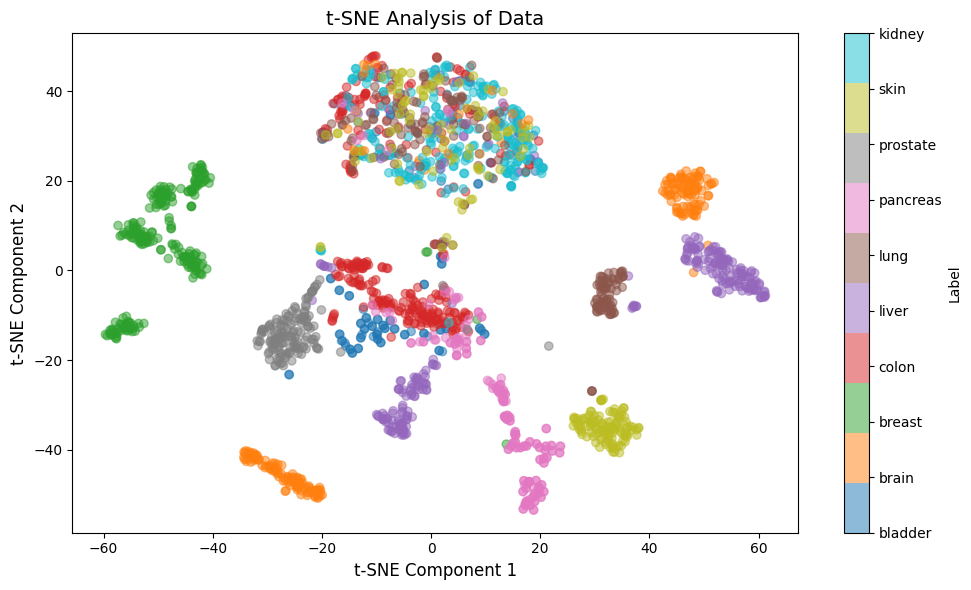

In [18]:
# Create a new DataFrame with the t-SNE embeddings and numeric labels
tsne_df = pd.DataFrame(data=embeddings, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = label_values

# Create a custom color map with 10 distinguishable colors
num_labels = len(label_mapping)
color_map = cm.get_cmap('tab10', num_labels)

# Create the scatter plot of the t-SNE embeddings
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], c=tsne_df['Label'], cmap=color_map, alpha=0.5)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Analysis of Data', fontsize=14)

# Customize the legend with actual label mappings
legend_labels = [label_mapping[i] for i in range(num_labels)]
plt.colorbar(scatter_plot, label='Label', ticks=range(num_labels)).set_ticklabels(legend_labels)

plt.tight_layout()
plt.show()

t-SNE plot of the GEO data seems to be far more separable then TCGA. Almost all of the cancer types have their own clusters, with only one cluster at the center top grouping various cancer types which seem to be indestinguishable from each other. 

It is worth noting that the cluster is mostly made of kindey cells, so we can confirm in the confusion matrix this will be the least accurate class.